# Load Constrained Layout Optimization

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/layout_and_loads.ipynb) (requires google account)


In this example, a simple layout optimization is done while adding the fatigue loads of the turbine as constraints in addition to the boundary and spacing constraints. This type of optimization is important to make sure that the loading on the turbines do not increase too much and compromise a component's integrity.

Load calculations of the Damage Equivalent Loads (DEL) and Lifetime Damage Equivalent Loads (LDEL) are computed via PyWake for the turbines and flow cases selected. Then, the load constraints can be included either with the `AEPMaxLoadCostModel` or as **post_constraints** in the `TopFarmProblem`. Both types of set ups are included in this example.

**Install TOPFARM and PyWake if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**First we import basic Python elements and some TOPFARM classes**

In [1]:
import numpy as np
from numpy import newaxis as na
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from topfarm.cost_models.cost_model_wrappers import AEPMaxLoadCostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot, XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

from py_wake.examples.data.lillgrund import LillgrundSite
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.turbulence_models.stf import STF2017TurbulenceModel
from py_wake.examples.data.iea34_130rwt import IEA34_130_1WT_Surrogate 
from py_wake.superposition_models import MaxSum

**Next, we select the site and wind turbine to use**.

Usually, adding the loads as constraints into Topfarm's problem requires an accurate calculation of the fatigue loading, which here is done by a surrogate of the IEA3 3.4MW turbine. In addition, it is necessary to specify a turbulence model (`STF2017TurbulenceModel`) that is adequate enough to represent the turbulence intensity in the site, which the surrogate model for the turbine will need for the load calculation.

In [2]:
%%capture
site = LillgrundSite()
windTurbines = IEA34_130_1WT_Surrogate()
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines, turbulenceModel=STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=MaxSum()))

#choosing the flow cases for the optimization - this will determine the speed and accuracy of the simulation
wsp = np.asarray([10, 15])
wdir = np.arange(0,360,45)

**Next, we set up the load constraint**

In this example, we will calculate nominal loads and use this as a basis for the load constraint. The loads are represented by the Lifetime Damage Equivalent Loads (LDEL).

In [3]:
%%capture
x, y = site.initial_position.T

#keeping only every second turbine as lillegrund turbines are approx. half the size of the iea 3.4MW
x = x[::2]
y = y[::2]
x_init = x
y_init = y
n_wt = x.size
i = n_wt

#choosing a load ratio for the constraint
load_fact = 1.002
simulationResult = wfm(x,y,wd=wdir, ws=wsp)
nom_loads = simulationResult.loads('OneWT')['LDEL'].values
max_loads = nom_loads * load_fact
s = nom_loads.shape[0]
load_signals = ['del_blade_flap', 'del_blade_edge', 'del_tower_bottom_fa',
                'del_tower_bottom_ss', 'del_tower_top_torsion']

**Setting up optimization problem**

For this optimization, we use the `AEPMaxLoadCostModelComponent` cost model component which already includes the maximum allowable loads as constraints. This means that the **post_constraint** element in the TOPFARM problem is not necessary.

In [4]:
#parameters needed for the optimization
maxiter = 10
tol = 1e-4
driver = EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol)
ec = 1e-2
step = 1e-4
min_spacing = 260

#setting up the boundary
xi, xa = x_init.min()-min_spacing, x_init.max()+min_spacing
yi, ya = y_init.min()-min_spacing, y_init.max()+min_spacing
boundary = np.asarray([[xi, ya], [xa, ya], [xa, yi], [xi, yi]])

#setting up cost function - aep and nominal loads calculation
def aep_load_func(x, y):
    simres = wfm(x, y, wd=wdir, ws=wsp)
    aep = simres.aep().sum()
    loads = simres.loads('OneWT')['LDEL'].values
    return [aep, loads]

In [5]:
#cost component and topfarm problem
cost_comp = AEPMaxLoadCostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt = n_wt,
                                          aep_load_function = aep_load_func,
                                          max_loads = max_loads, 
                                          objective=True,
                                          step={'x': step, 'y': step},
                                          output_keys=[('AEP', 0), ('loads', np.zeros((s, i)))]
                                          )

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                         n_wt=n_wt,
                        constraints=[XYBoundaryConstraint(boundary),
                                     SpacingConstraint(min_spacing)],
                          cost_comp=cost_comp,
                          driver=driver,
                          plot_comp=NoPlot(),
                          expected_cost=ec)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


**Now we run the optimization**

In [6]:
%%capture
cost, state, recorder = problem.optimize()

**We can also do some plotting to visualize the evolution of the AEP and loads for each iteration**

Text(0, 0.5, 'AEP [GWh]')

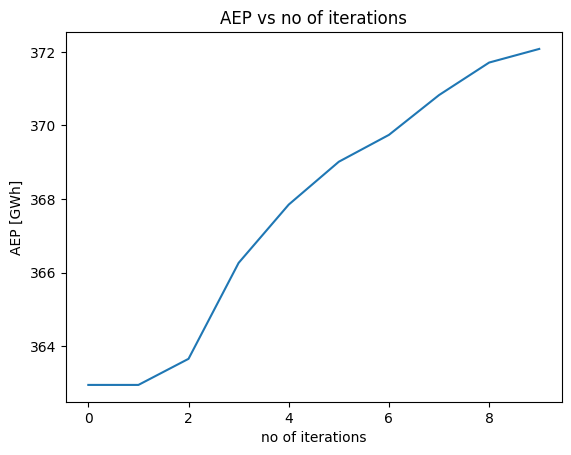

In [7]:
plt.plot(recorder['AEP'])
plt.title('AEP vs no of iterations')
plt.xlabel('no of iterations')
plt.ylabel('AEP [GWh]')

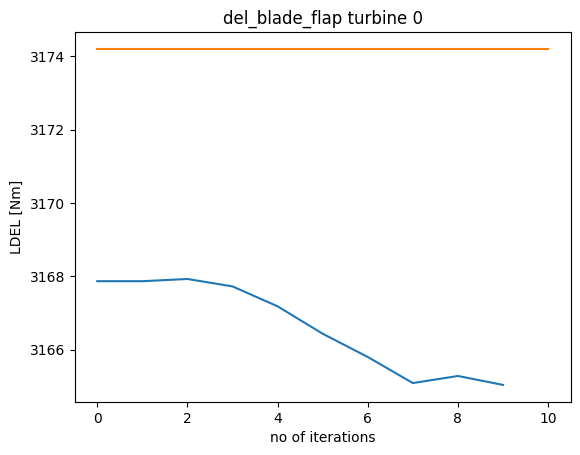

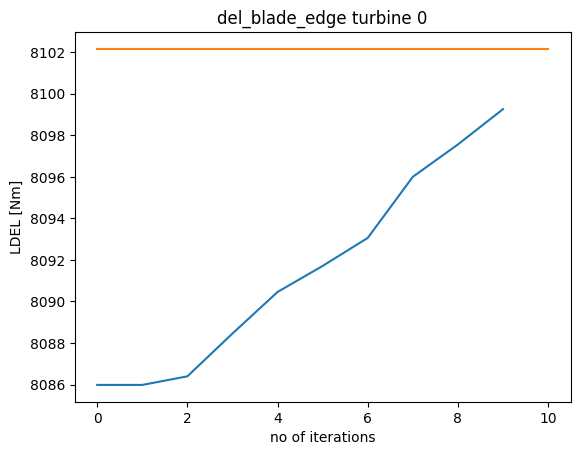

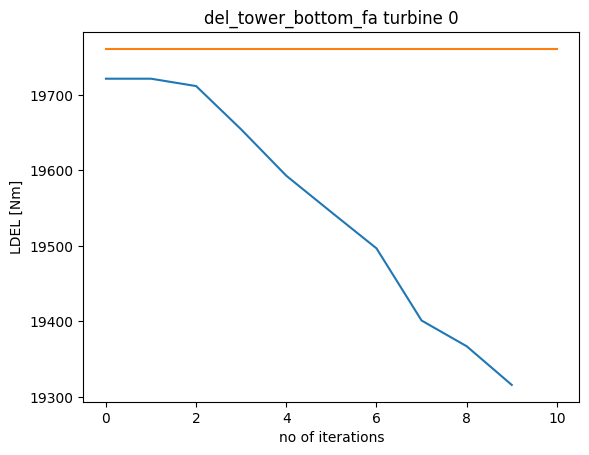

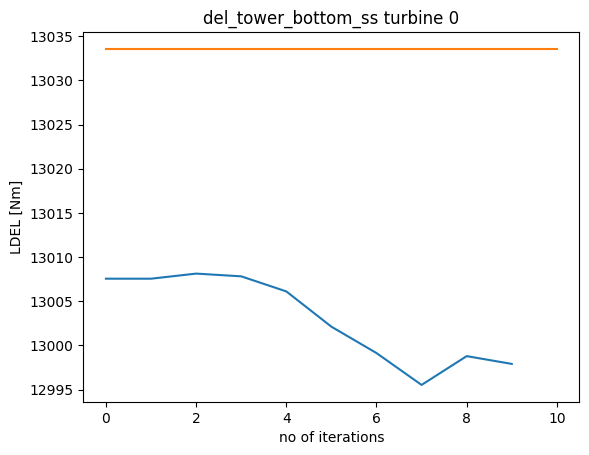

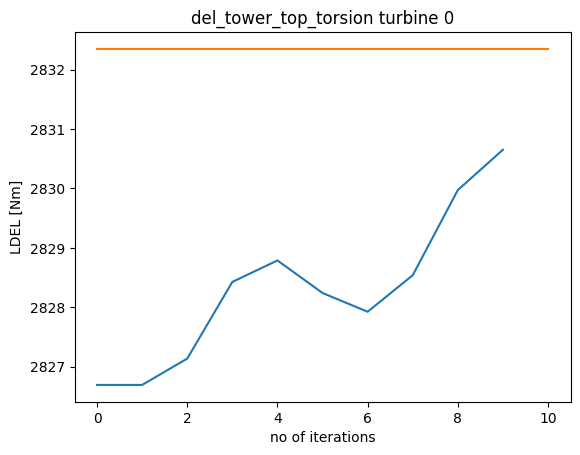

In [8]:
n_i = recorder['counter'].size
loads = recorder['loads'].reshape((n_i,s,n_wt))
wt = 0
for n, ls in enumerate(load_signals):
    plt.plot(loads[:,n,wt])
    plt.title(ls+f' turbine {wt}')
    plt.plot([0, n_i], [max_loads[n, wt], max_loads[n, wt]])
    plt.xlabel('no of iterations')
    plt.ylabel('LDEL [Nm]')
    plt.show()

### Note:

Due to the computational expensive nature of this problem, the maximum number of iterations were restricted to 10, for educational purposes. To see a convergence in loading and AEP, the number of iterations must be increased.

### Setting up the load constraints as post_constraints

Alternatively to using the `AEPMaxLoadCostModelComponent`, the common `CostModelComponent` can also be used any load constrained problem. The main difference lies in the way the load constraints are specified within the `TopFarmProblem`. You should set up the load constraint as a **post_constraints** element. Below is an example on how to set up this type of problem.

In [10]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

#redifining the cost function to output arrays instead of float

cost_comp = CostModelComponent([('x', x_init), ('y', y_init)],
                            n_wt=n_wt,
                            cost_function=aep_load_func,
                            objective=True,
                            output_keys=[('AEP', 0), ('loads', np.zeros((s, i)))])

#parameters for optimization
maxiter = 5
tol = 1e-4
ec = 1

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                          n_wt = n_wt,
                          post_constraints=[('loads', {'upper': max_loads})],
                          constraints=[XYBoundaryConstraint(boundary),
                                     SpacingConstraint(min_spacing)],
                          cost_comp=cost_comp,
                          driver=driver,
                          plot_comp=NoPlot(),
                          expected_cost=ec)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


We can evaluate the topfarm problem to make sure it is set up properly without having to run the optimization again.

In [11]:
%%capture
problem.evaluate()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


Evaluating the topfarm problem yields the initial conditions in terms of AEP and position of the turbines:

    (362.94298203172417,
     {'x': array([361469., 360936., 360404., 359871., 360936., 360404., 359871.,
             359338., 360670., 360137., 359604., 359071., 360404., 359871.,
             359071., 360390., 359871., 359071., 359871., 359338., 358805.,
             359338., 358805., 359071.]),
      'y': array([6154543., 6153946., 6153349., 6152753., 6154396., 6153800.,
             6153203., 6152606., 6154548., 6153952., 6153355., 6152758.,
             6154701., 6154104., 6153209., 6155136., 6154554., 6153659.,
             6155005., 6154408., 6153811., 6154858., 6154262., 6155010.])})